# COGS 108 - EDA Checkpoint

# Names

- Nhan Quach
- Joseph Morales
- Victor Wang
- Kevin Hu
- Areen Lu

<a id='research_question'></a>
# Research Question

How has social perception of profanity shifted across the past 20 years as indicated by the proportion of profane words utilized within the top 10 movies over the past 20 years and their respective age ratings, box office performance, and review scores?

# Setup

In [2]:
import pandas as pd
import numpy as np

# Import seaborn and apply its plotting styles
import seaborn as sns
sns.set(font_scale=2, style="white")

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
# set plotting size parameter
plt.rcParams['figure.figsize'] = (12, 5)

#import stat models
from sklearn import svm
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Data Cleaning

Describe your data cleaning steps here.

## Profane Words Data

In [ ]:
import csv

# Define a dictionary containing all relevant profane words to find
search_words = {'bastard': 0, 'bitch': 0, 'crap': 0, 'cunt': 0, 'damn': 0, 'fuck': 0, 'shit': 0, 'total': 0}

filename = "input_file.txt"

# Open the file for reading
with open(filename, "r") as file:
    # Loop through each line in the file
    for line in file:
        # Loop through each word in the dictionary
        for word in search_words:
            # Count the number of occurrences, including word substrings, in each line
            count = line.count(word)
            # If count is greater than zero, increment count for the word
            if count > 0:
                search_words[word] += count

# Sum all the values in the dictionary and add them to the 'total' key
search_words['total'] = sum(search_words.values())

# Drop the ".txt" extension from the input file name
file_basename = filename.split('.')[0]

# Write the contents of the dictionary to a CSV file
with open('search_words.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the headers to the first row of the CSV file
    headers = ['id'] + list(search_words.keys())
    writer.writerow(headers)
    # Write the values to the CSV file
    values = [file_basename] + list(search_words.values())
    writer.writerow(values)

The code above is used to search for profane words in a script file. The words to search for are stored in a dictionary called 'search_words'. In the script file, the code iterates through each line and counts all instances of the word or words as substrings. The count is incremented after each line. After reaching the end of the file, the total number of profane words is counted up and stored in the total key in the dictionary. The contents of the dictionary are written to a CSV file, where the first column is the ID of the script file without the '.txt' extension, and the remaining columns are the profane words and total count.

**Note:** Words such as 'ass', 'dick', 'pussy', and others were omitted as they could potentially result in false counts. For example, when looking for 'ass', words such as 'assumption', 'assign', 'class', and others would be counted although they are not profane words. Another example is 'pussy', where words like 'pussycat' would be counted despite not being used as profanity in a given context.

# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

## Profane Words Data

In [3]:
df = pd.read_csv('cleaned_data/movie_profane_words_count.csv')
df.head()

,id,bastard,bitch,crap,cunt,damn,fuck,shit,total
0,377062,2,1,2,0,6,1,30,42
1,1189340,1,10,0,0,7,4,18,40
2,120828,0,3,1,0,3,1,13,21
3,338013,0,1,5,0,7,30,18,61
4,460989,28,1,1,1,1,46,8,86


The data presented counts the number of profane words in each movie (represented by id) script. Each column counts the specified word and any words that contain the word as a substring. For example, words such as 'motherf-ker', 'f-ker', 'f-king', and 'f-k' would all be counted the same column.

In [4]:
column_sums = df.iloc[:, 1:-1].sum()
print(column_sums)

bastard     2144
bitch       6907
crap        2331
cunt         605
damn       12948
fuck       61294
shit       31991
dtype: int64


By counting the total number of words it each column, it is evident that the most commonly used words are 'sh-t', 'f-k', and 'd-mn'. The usage of these three words are approximately 10 times more frequent than other words on the list.

Text(0.5, 1.0, 'Frequency of Profane Words')

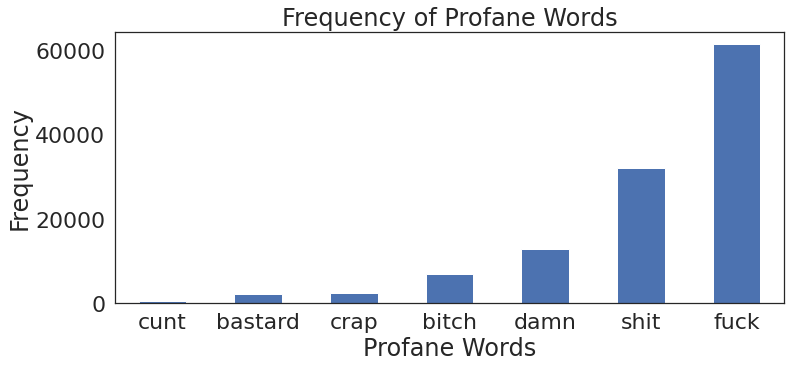

In [5]:
column_sums_sorted = column_sums.sort_values(ascending=True)
plt = column_sums_sorted.plot(kind='bar', rot=0)
plt.set_xlabel('Profane Words')
plt.set_ylabel('Frequency')
plt.set_title('Frequency of Profane Words')

From this chart, it is evident that the word 'f-k' is the the most frequently used word. The usage of this word is greater than the second and third words combined.

Text(0.5, 1.0, 'Most Used Word vs Total Words')

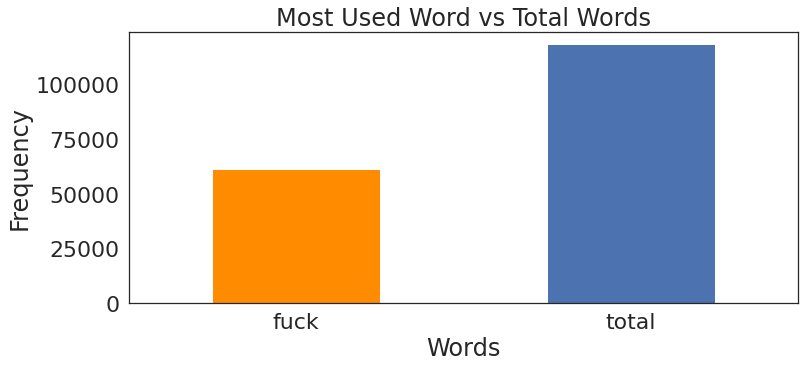

In [10]:
f_word_count = df['fuck'].sum()
total_word_count = df['total'].sum()

quantities = pd.Series([f_word_count, total_word_count], index=['fuck', 'total'])

colors = ['#FF8C00', '#4C72B0']
plt = quantities.plot(kind='bar', color=colors,  rot = 0)

plt.set_xlabel('Words')
plt.set_ylabel('Frequency')
plt.set_title('Most Used Word vs Total Words')

Comparing the total count of all profane words to the the total count of 'f-k', it can be seen how frequently this word appears. It accounts for approximately 60% of all profane words used.

(0.0, 677.0)

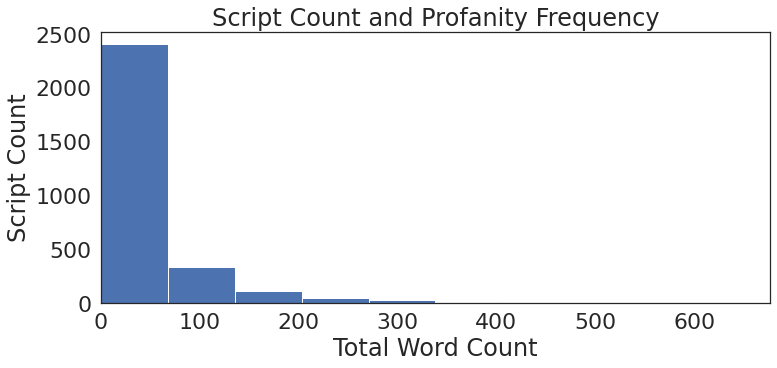

In [12]:
# create the histogram
total = df['total']
plt = total.plot(kind='hist', bins=10)

# set labels and title
plt.set_xlabel('Total Word Count')
plt.set_ylabel('Script Count')
plt.set_title('Script Count and Profanity Frequency')

plt.set_xlim([0,total.max()])

Most of the scripts in the dataset contain 50 or fewer profane words, with over 2000 scripts in this category. The second most common category is 50 to 100 profane words, but this only applies to less than 500 scripts. On the other end of the spectrum, there are a few scripts that contain over 600 profane words.

## Movie Data

In [88]:
dfWords  = pd.read_csv('cleaned_data/movie_profane_words_count.csv')
dfMeta = pd.read_csv("cleaned_data/cleaned_metadata_2023-03-10_20-36-27.csv")
dfMeta = dfMeta.rename(columns={"imdbId":"id"})
dfMeta["id"] = pd.to_numeric(dfMeta["id"])
dfWords["id"] = pd.to_numeric(dfWords["id"])
dfTotal = pd.merge(dfMeta,dfWords, on = "id")
dfTotal['normTotal'] = dfTotal['total']/dfTotal['script_size']
dfPredict = dfTotal.drop([254])

<AxesSubplot:xlabel='release_date', ylabel='total'>

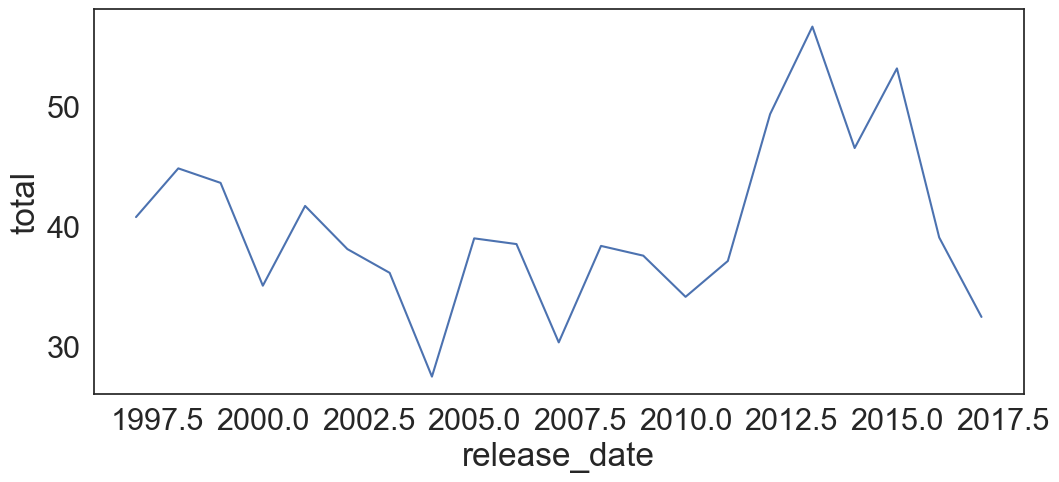

In [35]:
swearCountsMean = pd.DataFrame(dfTotal.groupby('release_date').mean()['total'])
sns.lineplot(data = swearCountsMean, x = "release_date", y = "total")

Looking at the average number of profane words per movie we can see that there appears to be a slight downward trend over time from 1997 to 2011, with a sharp increase from 2011 to 2012 followed by a dropoff. This does not take into account the number of words in the script overall, however, which we can account for by looking at the proportion of profane words in a script.

<AxesSubplot:xlabel='release_date', ylabel='normTotal'>

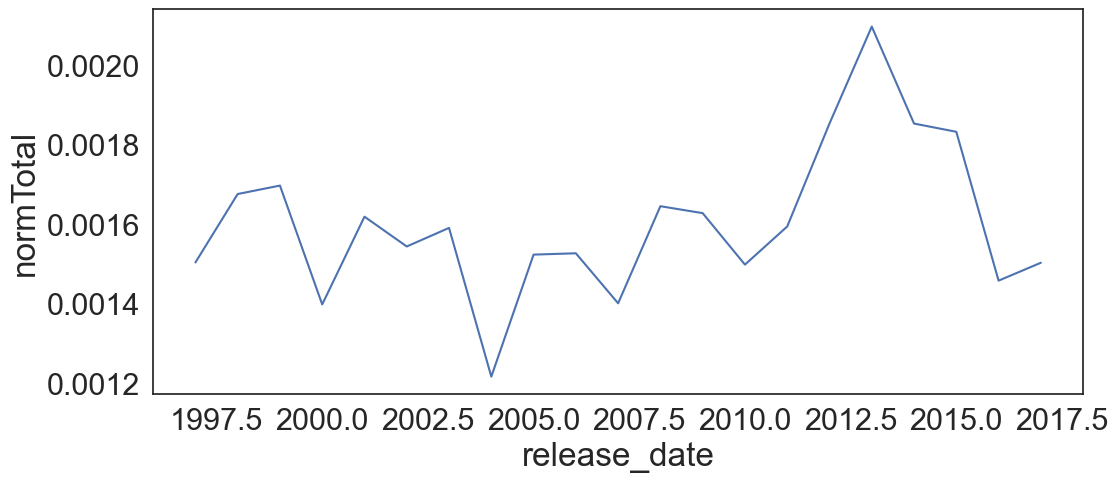

In [38]:
swearCountsMean = pd.DataFrame(dfTotal.groupby('release_date').mean()['normTotal'])
sns.lineplot(data = swearCountsMean, x = "release_date", y = "normTotal")

Looking at the proportional data, we can see that there 

<AxesSubplot:xlabel='release_date', ylabel='rating'>

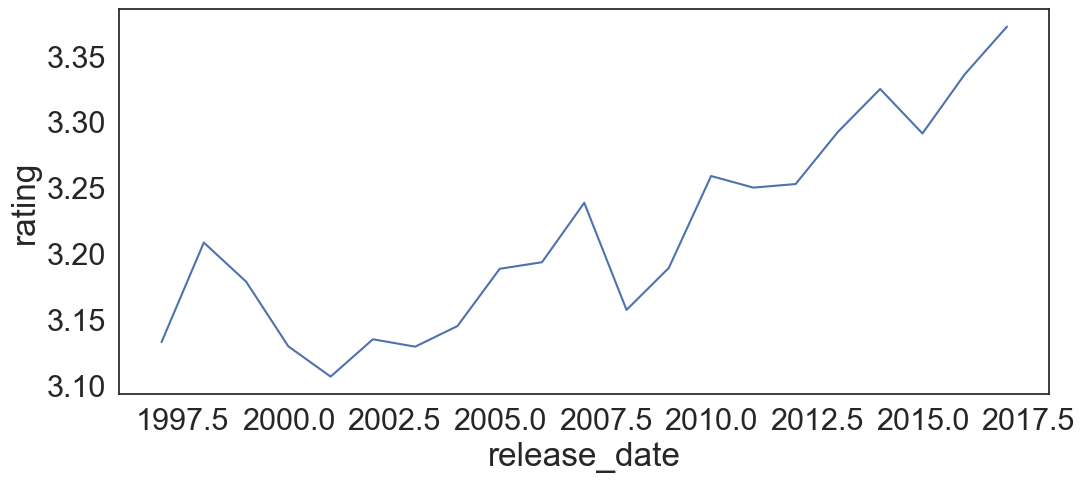

In [120]:
ratingsCountsMean = pd.DataFrame(dfTotal.groupby('release_date').mean()['rating'])
sns.lineplot(data = ratingsCountsMean, x = "release_date", y = "rating")

<AxesSubplot:xlabel='release_date', ylabel='revenue'>

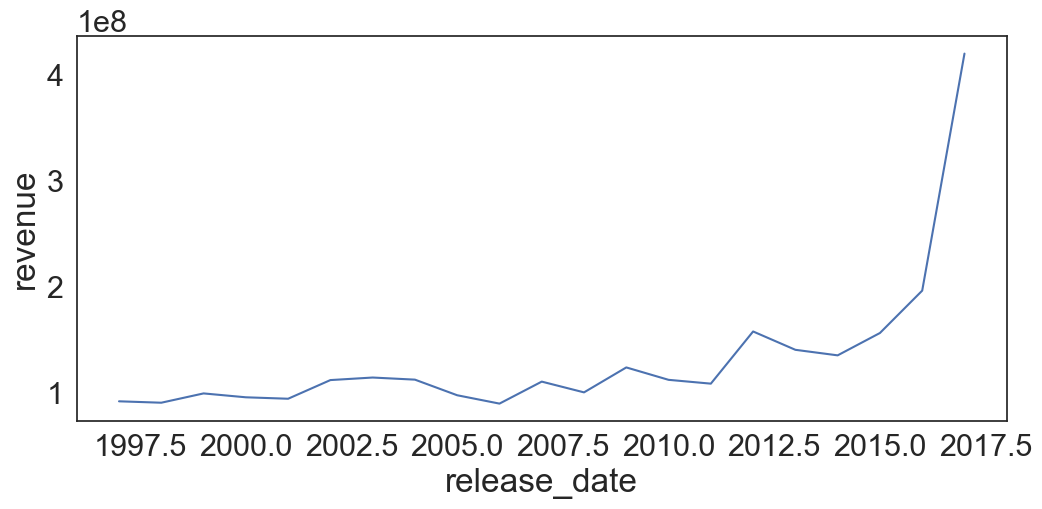

In [121]:
boxCountsMean = pd.DataFrame(dfTotal.groupby('release_date').mean()['revenue'])
sns.lineplot(data = boxCountsMean, x = "release_date", y = "revenue")

<AxesSubplot:xlabel='release_date', ylabel='normTotal'>

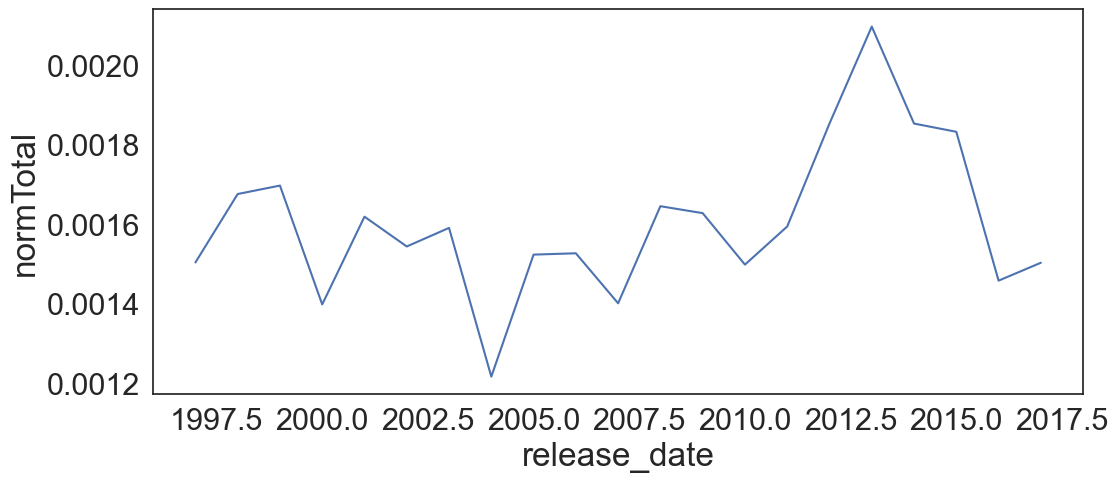

In [81]:
profanePrecentMean = pd.DataFrame(dfTotal.groupby('release_date').mean()['normTotal'])
sns.lineplot(data = profanePrecentMean, x = "release_date", y = "normTotal")

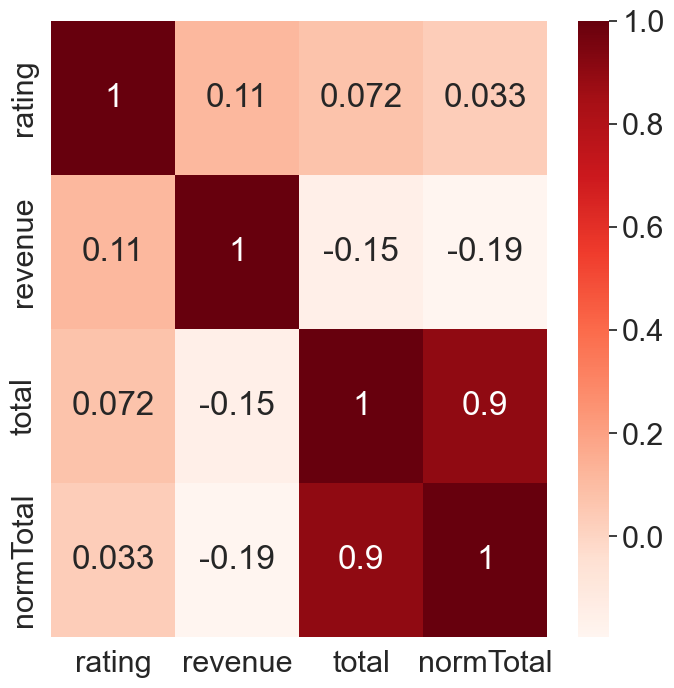

In [93]:
df_corr = dfTotal[['mpaa_rating','total','normTotal','rating','revenue']]
plt.figure(figsize=(8,8))
cor = df_corr.corr(method='pearson').sort_values(['rating'],ascending=False)
cor = cor[cor.index]
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [104]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

spearmanr(dfPredict['normTotal'],dfPredict['rating'])
spearmanr(dfPredict['normTotal'],dfPredict['revenue'])

SpearmanrResult(correlation=-0.30458188744476833, pvalue=3.2053272921387285e-64)

In [127]:
pearsonr(profanePrecentMean['normTotal'],ratingsCountsMean['rating'])
#spearmanr(profanePrecentMean['normTotal'],boxCountsMean['revenue'])

PearsonRResult(statistic=0.3477544230427529, pvalue=0.12241827432564542)

In [9]:
regr = svm.SVR()
regr.fit(dfPredict['rating'].values.reshape(-1,1),dfPredict['normTotal'].values.reshape(-1,1))
regr.predict([[0.000113]])

/Users/victorwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.00924813])

In [75]:
dfTotal

,adult,genres,release_date,revenue,title,id,rating,review_count,script_size,has_script,mpaa_rating,bastard,bitch,crap,cunt,damn,fuck,shit,total,normTotal
0,False,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",1997,3.395661e+07,The Relic,120004,2.815600,2359,25617.0,True,R,0,1,1,0,8,11,13,34,0.001327
1,False,"[{'id': 18, 'name': 'Drama'}]",1997,3.028094e+06,Dangerous Ground,118927,2.640086,232,17787.0,True,R,3,2,0,0,11,58,24,98,0.005510
2,False,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",1997,2.154540e+06,Shadow Conspiracy,120107,2.773481,362,20253.0,True,R,2,2,1,0,7,9,6,27,0.001333
3,False,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",1997,1.179002e+06,Nightwatch,119791,3.100465,861,15670.0,True,R,1,1,0,0,5,19,11,37,0.002361
4,False,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",1997,2.580471e+07,Murder at 1600,119731,3.084111,3216,18696.0,True,R,0,2,0,0,2,2,9,15,0.000802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,False,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",2017,2.323802e+08,Alien: Covenant,2316204,3.054054,333,20518.0,True,R,0,1,1,0,4,42,18,66,0.003217
2940,False,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",2017,4.077780e+08,The Mummy,2345759,2.630252,119,15929.0,True,PG-13,1,2,0,0,2,0,1,6,0.000377
2941,False,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",2017,1.238765e+09,The Fate of the Furious,4630562,3.172764,246,26023.0,True,PG-13,0,5,0,0,12,1,20,38,0.001460
2942,False,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",2017,2.245113e+08,Baby Driver,3890160,3.973244,299,25248.0,True,R,0,5,0,0,14,67,30,116,0.004594


normTotal
release_date mpaa_rating           
1997         G             0.000000
             NC-17         0.003238
             PG            0.000185
             PG-13         0.000508
             R             0.002278
...                             ...
2016         PG-13         0.000399
             R             0.002834
2017         PG            0.000029
             PG-13         0.000634
             R             0.003220

[86 rows x 1 columns]

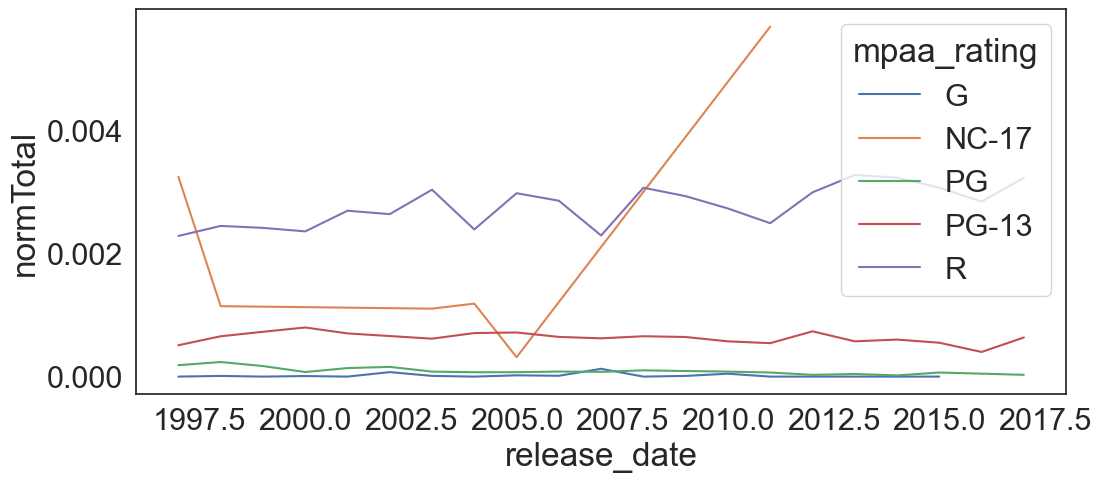

In [67]:
dfTemp = dfTotal[(dfTotal.mpaa_rating != 'Not Rated') & (dfTotal.mpaa_rating != 'TV-MA') & (dfTotal.mpaa_rating != 'Unrated')]
ratingCountsMean = pd.DataFrame(dfTemp.groupby(['release_date','mpaa_rating']).mean()['normTotal'])
sns.lineplot(data = ratingCountsMean, x='release_date', y = 'normTotal',hue = 'mpaa_rating')
ratingCountsMean

In [91]:
x = dfPredict['normTotal']
y = dfPredict['revenue']
x = sm.add_constant(x)

model = sm.OLS(y,x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     115.7
Date:                Sat, 18 Mar 2023   Prob (F-statistic):           1.74e-26
Time:                        15:57:41   Log-Likelihood:                -60291.
No. Observations:                2943   AIC:                         1.206e+05
Df Residuals:                    2941   BIC:                         1.206e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.486e+08    4.4e+06     33.796      0.0

eval_env: 1


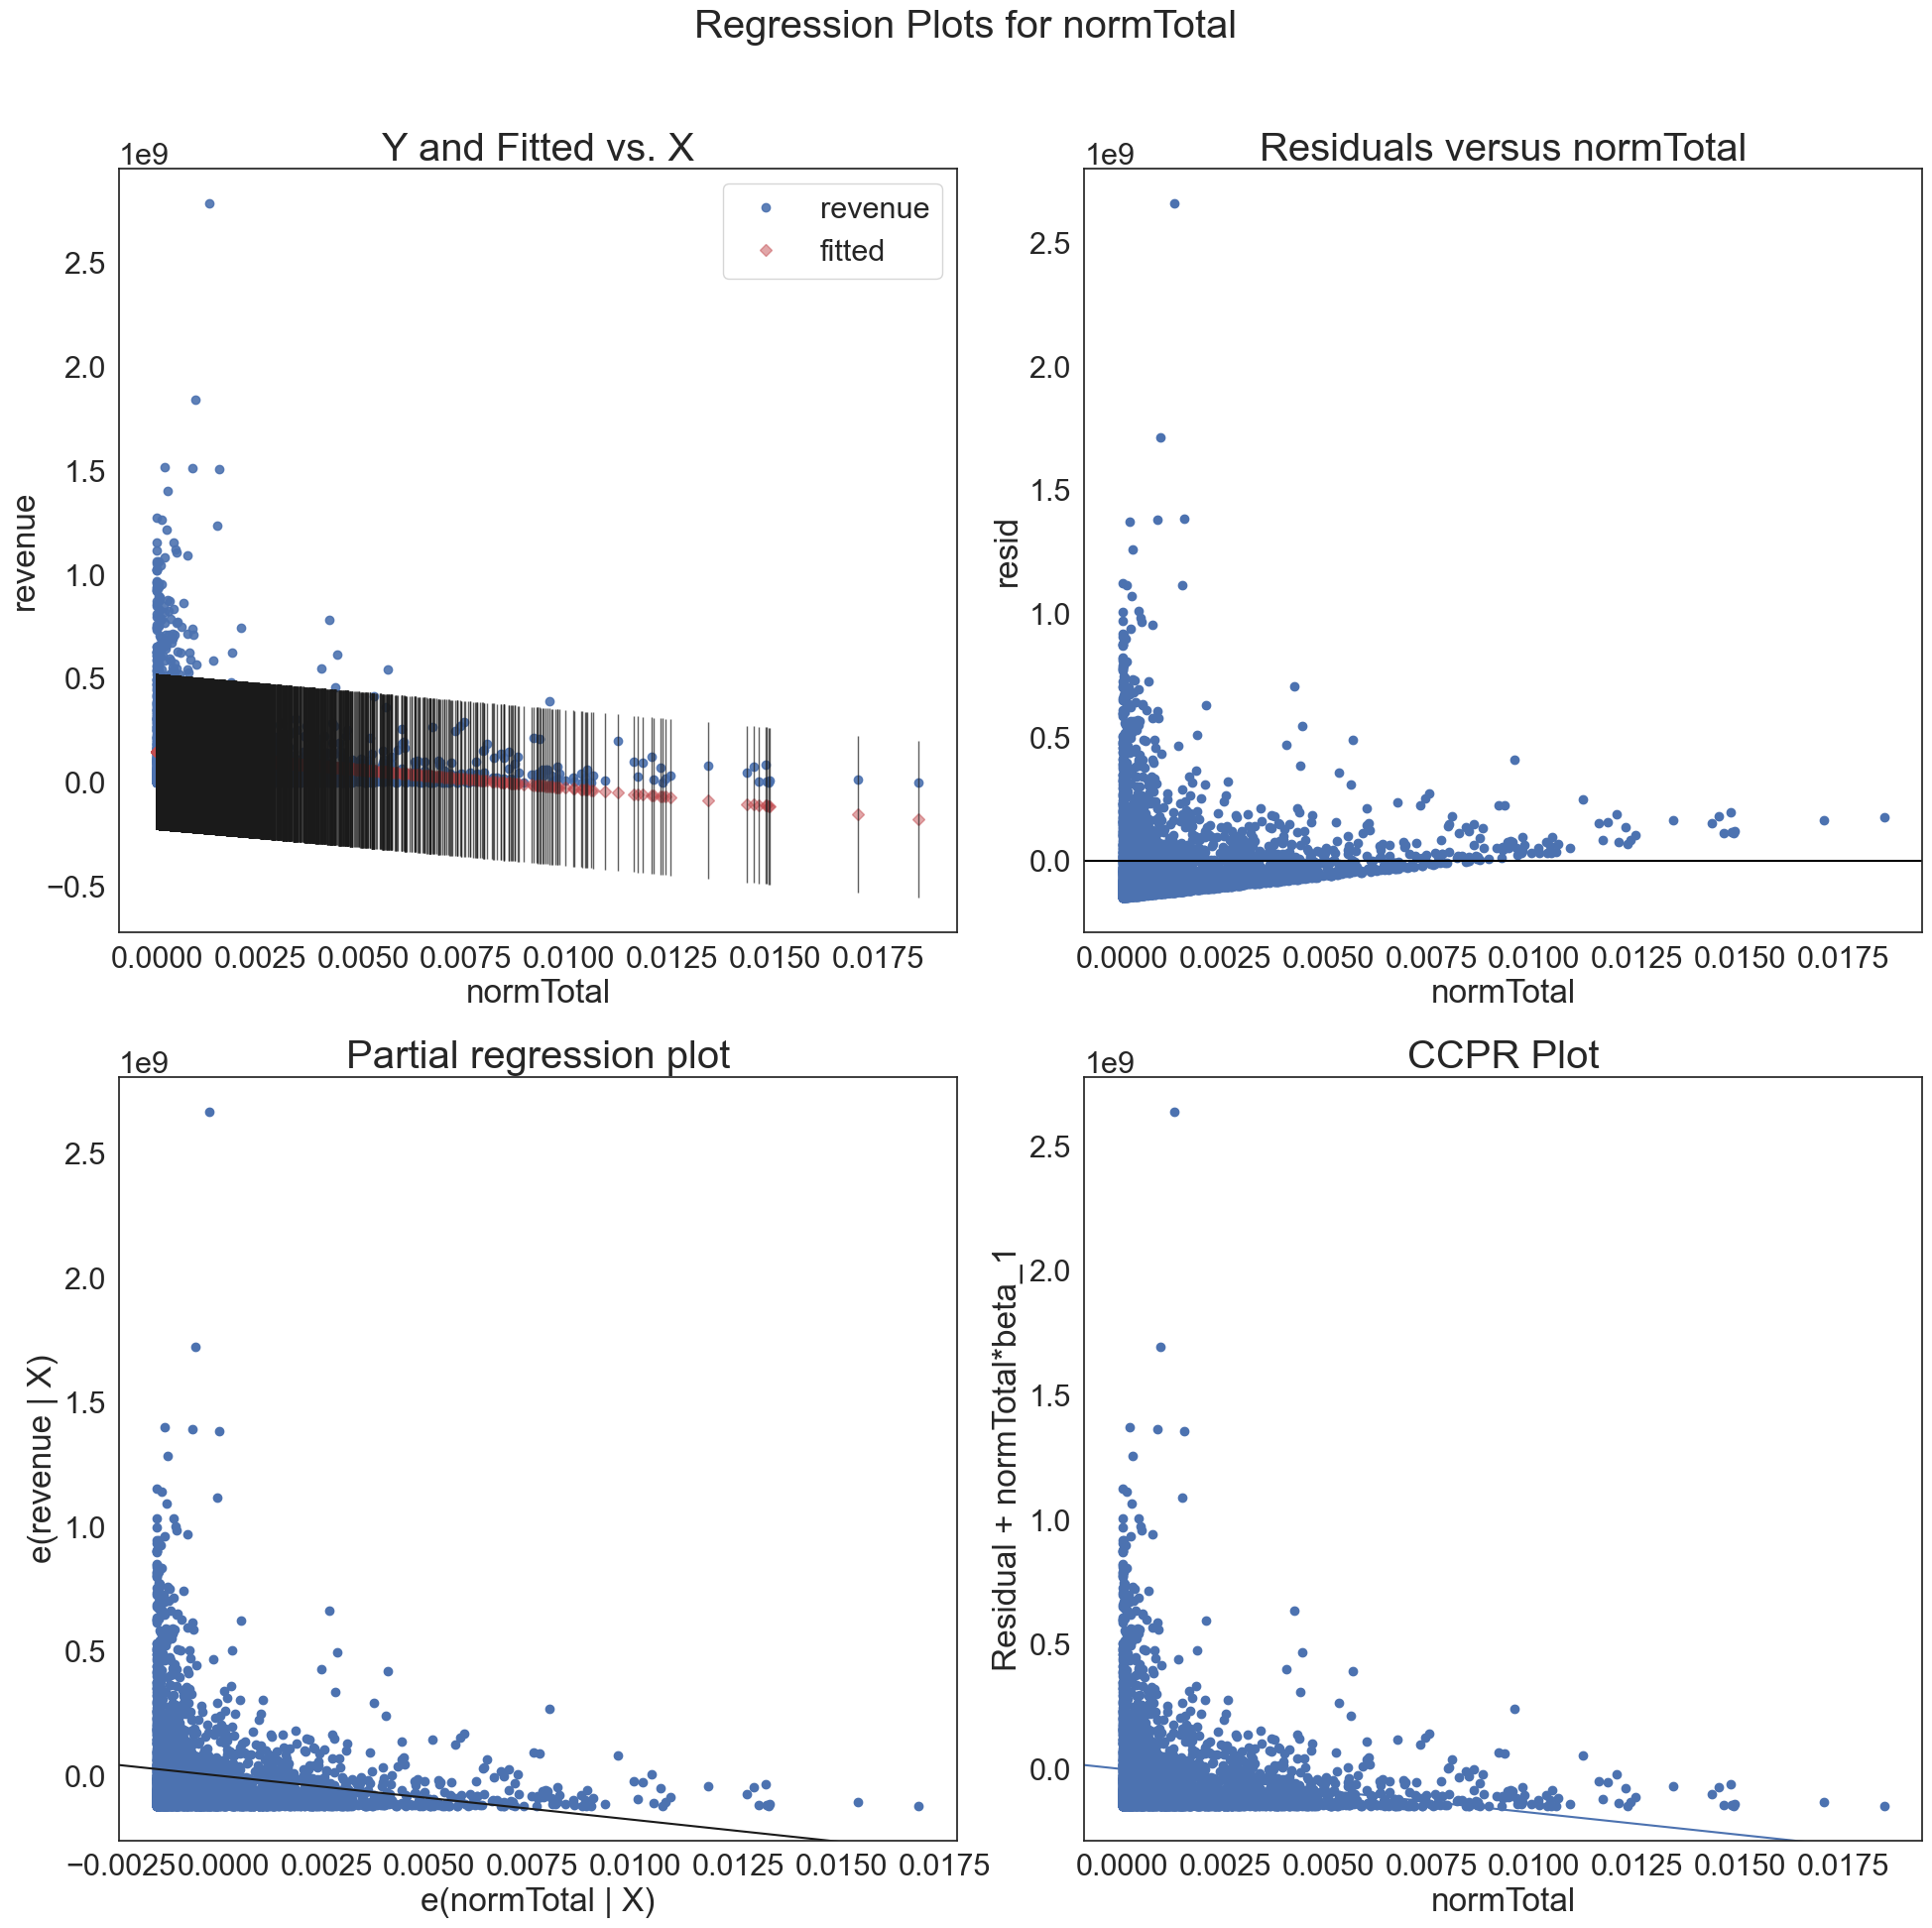

In [92]:
fig = plt.figure(figsize=(20,20))
fig = sm.graphics.plot_regress_exog(model,'normTotal',fig=fig)

In [94]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X = sm.add_constant(X)
    result = sm.OLS(Y, X).fit()
    return result.params

def regressYear(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X = sm.add_constant(X)
    result = sm.OLS(Y, X).fit()
    return result.rsquared

dfPredict.groupby('release_date').apply(regressYear, 'rating', 'normTotal')

release_date
1997    0.011954
1998    0.028154
1999    0.010263
2000    0.022721
2001    0.009500
2002    0.005994
2003    0.000899
2004    0.028756
2005    0.000002
2006    0.020065
2007    0.007385
2008    0.002862
2009    0.000951
2010    0.001581
2011    0.000052
2012    0.000584
2013    0.000907
2014    0.000860
2015    0.000099
2016    0.000688
2017    0.091089
dtype: float64

In [108]:
from statsmodels.tsa.stattools import adfuller

adft = adfuller(profanePrecentMean,autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

      Values                       Metric
0  -4.568002              Test Statistics
1   0.000148                      p-value
2   8.000000             No. of lags used
3  12.000000  Number of observations used
4  -4.137829          critical value (1%)
5  -3.154972          critical value (5%)
6  -2.714477         critical value (10%)


In [112]:
autocorrelation_lag1 = profanePrecentMean['normTotal'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)
autocorrelation_lag3 = profanePrecentMean['normTotal'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = profanePrecentMean['normTotal'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = profanePrecentMean['normTotal'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

One Month Lag:  0.42275211333448615
Three Month Lag:  0.035968634623145035
Six Month Lag:  -0.15285885570488844
Nine Month Lag:  -0.530720118914236


In [131]:
profanePrecentMean2 = profanePrecentMean
profanePrecentMean2['Years'] = [1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]

In [128]:
from statsmodels.tsa.seasonal import seasonal_decompose
df2 = dfPredict
df2.index = df2['release_date']
profanePrecentMean2.index = profanePrecentMean2['Years']
decompose = seasonal_decompose(profanePrecentMean2['normTotal'],model='additive', period=7)
decompose.plot()
plt.show()

KeyError: 'release_date'